# Mapping Inundation According to Flow Rates

**Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments**

### Background
Many of Australia's water bodies are regulated by humans. Flows are controlled by regulators such as the Murray Darling Basin Authority and local governments to meet the needs of water users while maintaining ecosystems dependant on the surface water. It is important that regulators know where the water goes when it goes overbank to help manage wetland inundations for environmental purposes and be informed of rural or residential areas likely to be flooded as a result of a large dam release. 

### The Problem 
Gauges have been placed along river systems all over Australia to monitor flow rates and water levels, however tracking where water goes when it spills over bank at a certain rate is challenging without combining the gauge data with satellite data.  

### Digital Earth Australia use case 
The Water Observations from Space (WOfS) dataset detects surface water in Australia based on Landsat data. By linking this dataset with gauge data, we can get information on where the water goes when it goes overbank according to flow rates measured by the gauge. Being able to see where water goes at different flow rates is valuable information for water regulators. 

### Description
In this example, we take gauge data and link it to WOfS data by date to create a summary image of water frequency according to a user-specified flow rate. The worked example demonstrates how to:

1. Generate a Flow Duration Curve from stream gauge data
2. Use Dask loading to link the WOfS dataset to the stream gauge data
3. Call WOfS data by flow rate as opposed to chronological time range
4. Cloud mask WOfS data
5. Generate a frequency image of water from the WOfS data

### Technical details
* **Products used:** [`wofs_albers`](https://explorer.sandbox.dea.ga.gov.au/wofs_albers),
[`BoM's Water Data Online`](http://www.bom.gov.au/waterdata/)
* **Analyses used:** Flow duration curve generation, Dask loading, inundation mapping

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, 

### Load Packages
Load key Python packages and supporting functions for the analysis. This notebook relies on a module called dea_bom, which is located in the Scripts file. 

In [1]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
import sys
sys.path.append('../Scripts')
import os
import pickle

from datacube.helpers import write_geotiff

from pathlib import Path
import dea_bom
import pandas as pd
import numpy as np
import xarray as xr
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

# Retrieve stream gauge data from the Water Data Online website


This box retrieves data from http://www.bom.gov.au/waterdata/ using the dea_bom module.

In [2]:
%%time
stations_pkl = Path('stations.pkl')

# if cache exists, get it from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))
    
len(stations), stations[:5]

Loading from cache
CPU times: user 7.03 ms, sys: 4.88 ms, total: 11.9 ms
Wall time: 10.6 ms


(6027,
 [namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
  namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
  namespace(name='15 MILE CK GLENROWAN', pos=(-36.47080718, 146.246199), url='http://bom.gov.au/waterdata/services/stations/403251'),
  namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
  namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318')])

## Plot a map of stations and select a gauge that contains data

Running this cell will generate a map displaying the locations of stream gauges in Australia. It will take about 20 seconds to load. Choose a gauge on the map by clicking on it. Note that after you click on a gauge it can take a second or two to respond. Also note that a few gauges have no data available and will retrieve zero observations, so you will have to click around until you find a gauge with good data. When you have the station you want, you must click the Done button before moving onto the next box. If you want to choose a different gauge after having pressed the Done button, you must re-run this box to regenerate the map then choose another gauge and press Done again. 

In [4]:
gauge_data, station = dea_bom.ui_select_station(stations);

## Generate a flow duration curve from the data selected above
The code in the box below will automatically select the latitude and longitude of the selected gauge, but you can enter a different lat and lon if you want by following the hashtag lines in the code below. The output will tell you what lat and lon has been selected. The buffer, which is the radius around the location point, is set to 8000 meters but you can change it if you like.

You have selected: lat = -34.5767
You have selected: lon = 142.7675


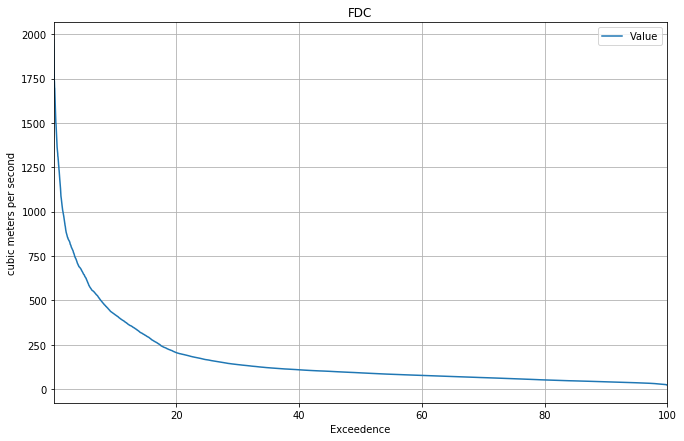

In [5]:
pos = station.pos

#The lat and lon takes the location of the gauge (pos). You can change the lat and lon to a different location if necessary, 
#just hashtag out this lat, lon = pos line below and define your own.
lat, lon = pos

#lat =
#lon = 

#The buffer is how many meters radius around the location you want to display.
buffer = 8000 

#Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100

#Plotting the flow duration curve
gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7))
plt.ylabel('cubic meters per second')
plt.grid(True)
plt.title('FDC')

print("You have selected: lat = {}".format(lat))
print("You have selected: lon = {}".format(lon))

## Enter the y-axis parameters in cubic meters per second

In [6]:
#What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 500
yaxis_higher_parameter = 1750

Hydrologists like to look at the flow duration curve on a log scale to better understand the extremeties of the flow rates. The next cell displays the selected part of the flow duration curve on a log scale.

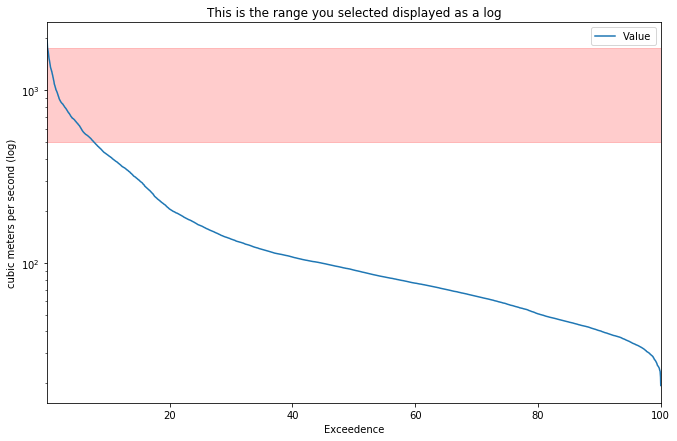

In [7]:
#Let's look at it on a log scale
ax2 = gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7)) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This is the range you selected displayed as a log')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = plt.yscale('log')

## Dask loading WOfS data
The next cell uses Dask to load only the parameters of the WOfS data without loading the images, which is a faster way to load WOfS data. Loading only the parameters is enough to link the WOfS dataset to the dataset from the stream gauge. The data are linked by date using XArray's .interp() function. The code then takes into account the flow rate parameters entered by the user and creates a list of dates where there was a satellite pass while the gauge was reading that value. The output tells the user how many passes there were.

In [8]:
gauge_data_xr = gauge_data.to_xarray()

#Dask loading wofs_albers data (loading parameters only, not loading the actual satellite data since 1988)
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-10-01'), # You can change this date accordingly
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

# Merging satellite data with gauge data by timestamp
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
date_list = specified_level.time.values

print("You are about to load this many satellite passes: {}".format(specified_level.time.shape[0]))

You are about to load this many satellite passes: 98


## Loading and cloud masking the selected WOfS data
The box below will load the selected WOfS images with .compute() and then cloud mask the images, meaning it will take out images that had too much cloud to see anything. It does this by using the .make_mask() function from the Geoscience datacube. The output will tell you how many passes remain after they were cloud masked. 

In [9]:
# load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# prune out "too cloudy" passes
cc = masking.make_mask(specified_passes.water, cloud=True)

npixels_per_slice = specified_passes.water.shape[1]*specified_passes.water.shape[2]
npixels_per_slice

ncloud_pixels = cc.sum(dim='x').sum(dim='y')
cloud_pixels_fraction = (ncloud_pixels/npixels_per_slice)

clear_specified_passes = specified_passes.water.isel(time=cloud_pixels_fraction<0.5)
print("After cloud masking, there are this many passes available: {}".format(clear_specified_passes.time.shape[0]))

After cloud masking, there are this many passes available: 66


## Generating an image of the waterbody based on flow
This cell will generate a water frequency image for the selected location using the passes indicated above. One large plot is generated for easy viewing. A small plot next to the flow duration curve with the selected parameters is generated to remind the user which part of flow duration curve the images relates to. 

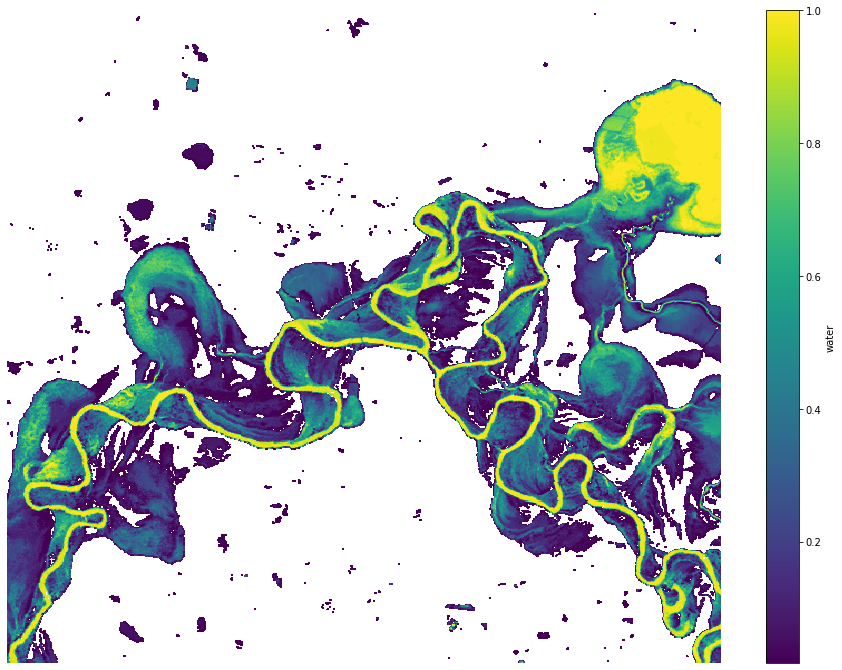

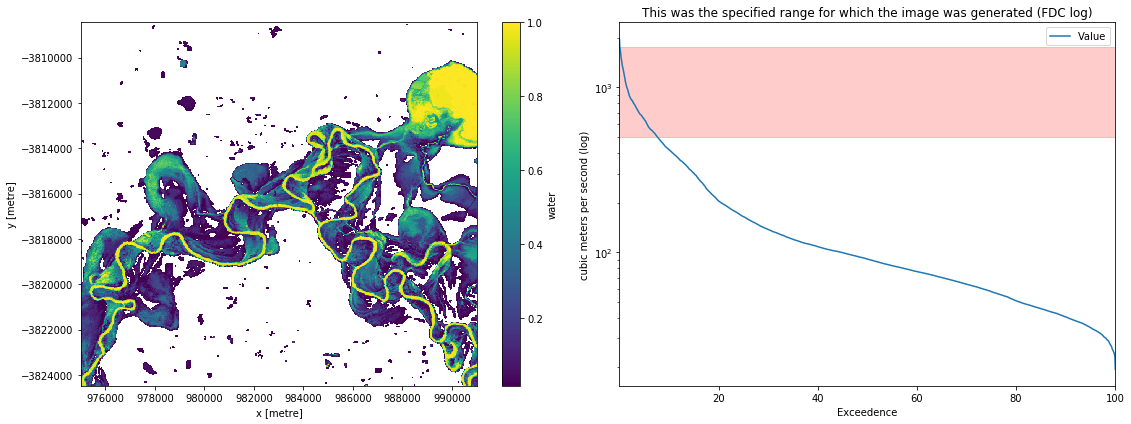

In [10]:
#Create parameters for the image
wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency.plot(figsize = (16, 12))
plt.axis('off')

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax1 = frequency.plot(ax=ax[0])

ax2 = gauge_data.plot(x='Exceedence', y='Value', ax=ax[1]) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This was the specified range for which the image was generated (FDC log)')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = plt.yscale('log')

plt.tight_layout()

## Save the file as a geotiff
You might want to use this image in another workflow, so here is some code that will save it as a .tif file for you. Enter a name for the .tif file below. The ../ part of the name means it will save this file one directory up from where this notebook is saved, ie in your dea-notebooks folder.

In [11]:
file_name = '../file_name_here.tif'

In [12]:
frequency_dataset = frequency.to_dataset()
frequency_dataset.attrs=wofs_albers.attrs
# Write geotiff to a location
write_geotiff(file_name, frequency_dataset)